In [1]:
from importlib import reload
from src import parsing
from src import model_path
from src import models_path
from src import model_goal
from src import models_goal
from src import model_interface
from src import visualization
from src import util
from src import config
reload(parsing)
reload(model_path)
reload(models_path)
reload(model_goal)
reload(models_goal)
reload(model_interface)
reload(visualization)
reload(util)
reload(config)

import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# file used for evaluating the atc dataset
file_path = "data/medium_aa.csv"

In [3]:
## load raw data into pandas
## modified from parsing.py:
df = pd.read_csv(file_path, names=["time", "id", "x", "y", "z", "velocity", "motion_angle", "facing_angle"])
df = df.drop(columns=['z', 'velocity', 'motion_angle', 'facing_angle'])
df['time'] = pd.to_datetime(df['time'], unit='s')

Min -41020, Max 48051, Mean 270.2975155, Std 19186.293111789735


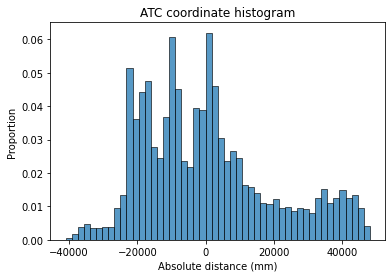

In [8]:
# for this we are only interested in the x and y columns
# combine these in a single 1D numpy array
raw_data = df.loc[:, ['x', 'y']].to_numpy().flatten()
plt.xlabel('Absolute distance (mm)')
plt.title('ATC coordinate histogram')
seaborn.histplot(data=raw_data, bins=50, stat='proportion')
plt.savefig("atc_coordinate_histogram_absolute.pdf")

print(f"Min {raw_data.min()}, Max {raw_data.max()}, Mean {raw_data.mean()}, Std {raw_data.std()}")

In [9]:
# scale df
df['x'] = df['x'] / config.SCALING_FACTOR
df['y'] = df['y'] / config.SCALING_FACTOR

Min -4.102, Max 4.8051, Mean 0.02702975155000001, Std 1.9186293111789734


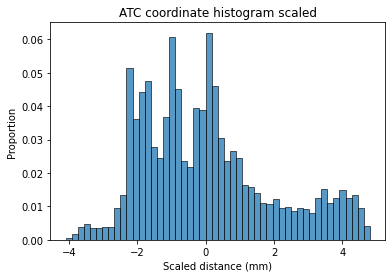

In [15]:
raw_data = df.loc[:, ['x', 'y']].to_numpy().flatten()

plt.xlabel('Scaled distance (mm)')
plt.title('ATC coordinate histogram scaled')
seaborn.histplot(data=raw_data, bins=50, stat='proportion')
plt.savefig("atc_coordinate_histogram_absolute_relative.pdf")

print(f"Min {raw_data.min()}, Max {raw_data.max()}, Mean {raw_data.mean()}, Std {raw_data.std()}")

In [11]:
# load testing data and format it for the model
train_data, eval_data, test_data = parsing.parse_atc_day(file_path, train_ratio=0.9, eval_ratio=0.1)

100%|██████████| 1224/1224 [00:17<00:00, 71.35it/s]


1224 unique ids found. Generated 248779 sequences total from 697 trajectories.
Skipped 503 trajectories.
        353 too short
        150 frequency issues (like gaps)
    
Skipped 441 sequences (0.177%) because of abnormally high absolute value after normalization
Dividing 697 human trajectories: 627 training, 70 eval, 0 test
train (223506, 40, 2) float64 (223506, 25) float32 (223506, 40, 2) float64
eval (25273, 40, 2) float64 (25273, 25) float32 (25273, 40, 2) float64


Min -0.9978416058039066, Max 0.9985649944158445, Mean 5.180189878067488e-06, Std 0.1726481259448845


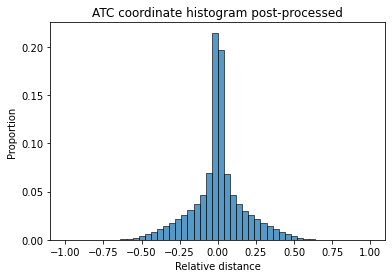

In [14]:
raw_data_x = train_data[0].flatten()
raw_data_y = train_data[2].flatten()
raw_data = np.concatenate((raw_data_x, raw_data_y))

plt.xlabel('Relative distance')
plt.title('ATC coordinate histogram post-processed')
seaborn.histplot(data=raw_data, bins=50, stat='proportion')
plt.savefig("atc_coordinate_histogram_postprocessed.pdf")

print(f"Min {raw_data.min()}, Max {raw_data.max()}, Mean {raw_data.mean()}, Std {raw_data.std()}")

<AxesSubplot:ylabel='Proportion'>

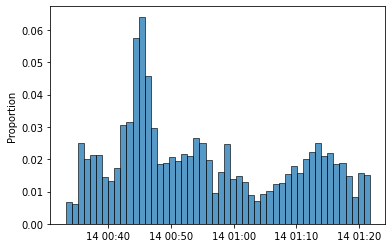

In [35]:
raw_data = df.loc[:, ['time']].to_numpy().flatten()
seaborn.histplot(data=raw_data, bins=50, stat='proportion')